In [3]:
import sklearn
import numpy as np
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
import re
import pickle

import warnings
warnings.filterwarnings('ignore')

# Reading the data from the database

In [4]:
conn = sqlite3.connect('../db.sqlite3')
df_raw = pd.read_sql_query("SELECT * FROM scraper_auto", conn)
df_raw

,id,kenteken,bouwjaar,kilometer_stand,vermogen,is_handgeschakeld,is_benzine,prijs,url,titel,upload_datum,bron,apk
0,1159,96-GZR-3,2008,117910.0,77,0.0,1,1.0,https://www.marktplaats.nl/a/auto-s/fiat/m1554...,Fiat Grande Punto 1.4 Edizione Lusso AUTOMAAT!,2020-05-23 15:01:00,marktplaats,2021-05-22
1,1160,90-ZJ-ZN,2008,169504.0,78,0.0,1,2950.0,https://www.marktplaats.nl/a/auto-s/fiat/m1556...,Fiat Grande Punto 1.4-16V Emotion 5dr Automaat...,2020-05-27 13:22:00,marktplaats,2020-10-18
2,1161,03-TR-LV,2007,219718.0,65,1.0,1,1950.0,https://www.marktplaats.nl/a/auto-s/fiat/m1558...,"Fiat Grande Punto 1.2 Edizione Cool AIRCO,CRUI...",2020-06-01 16:00:00,marktplaats,2020-12-12
3,1162,61-TF-FP,2006,199908.0,95,1.0,1,1895.0,https://www.marktplaats.nl/a/auto-s/fiat/m1558...,Fiat Grande Punto 1.4-16V Emotion AIRCO/APK,2020-06-01 14:11:00,marktplaats,2021-01-17
4,1163,62-ZL-SX,2008,138191.0,65,1.0,1,2740.0,https://www.marktplaats.nl/a/auto-s/fiat/m1558...,Fiat Grande Punto 1.2 Active Airco_rijdt prima,2020-06-01 13:56:00,marktplaats,2021-06-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1204,2398,86PJR4,2011,107994.0,86,1.0,0,3475.0,https://www.autoscout24.nl/aanbod/fiat-punto-e...,Fiat Punto Evo1.3 M-Jet Dynamic Zeer zuinig sl...,None,autoscout,2021-02-02
1205,2399,85PRB8,2011,196309.0,84,1.0,0,3495.0,https://www.autoscout24.nl/aanbod/fiat-grande-...,Fiat Grande Punto1.3 JTD Dynamic Airco Navi Cr...,None,autoscout,2021-01-01
1206,2400,08SKD5,2011,167537.0,84,1.0,0,3495.0,https://www.autoscout24.nl/aanbod/fiat-punto-e...,Fiat Punto Evo1.3 M-Jet Mylife,None,autoscout,2020-06-25
1207,2401,79RKG8,2011,180000.0,84,1.0,0,3495.0,https://www.autoscout24.nl/aanbod/fiat-punto-1...,Fiat Punto1.3 M-Jet Dynamic,None,autoscout,2019-06-06


# Used columns for the model

In [5]:
target_names = ["titel", "bouwjaar", "kilometer_stand", "vermogen", "prijs", "is_handgeschakeld", "is_benzine", "upload_datum", "apk"]

# Processing date columns
- Dates are converted to ordinal date from now
- Missing dates will be imputed using the mean

In [6]:
df = df_raw[target_names].dropna(axis=0)
df['upload_datum'] = pd.to_datetime(df['upload_datum'])
df['apk'] = pd.to_datetime(df['apk'])

average_upload_datum = df['upload_datum'].mean().toordinal()
average_apk =df['apk'].mean().toordinal()

def upload_datum_to_ordinal(date):
    if date is pd.NaT:
        return abs(datetime.now().toordinal() - average_upload_datum)
    else:
        return abs(datetime.now().toordinal() - date.toordinal())
    
def apk_to_ordinal(date):
    if date is pd.NaT:
        return abs(datetime.now().toordinal() - average_apk)
    else:  
        return abs(datetime.now().toordinal() - date.toordinal())

df['upload_datum'] = df['upload_datum'].apply(upload_datum_to_ordinal).astype(int)
df['apk'] = df['apk'].apply(apk_to_ordinal).astype(int)

# Process string columns
- All special characters are removed from the string
- All token with length < 3 are removed

In [7]:
def parse_titel(titel):
    cleaned = re.sub('[^a-zA-Z]+', ' ', titel.lower())
    stripped = line = re.sub(r'\b\w{1,3}\b', '', cleaned)
    
    return stripped

df['titel'] = df['titel'].apply(parse_titel)

# Removing outliers
- Range: 1 to 100.000

In [8]:
df = df[df['prijs'] > 1]
df = df[df['prijs'] < 100000]

# Plotting histograms and countplots for all relevant columns
Observations:
- After 200.000km the listings drop, should probabliy buy around 150.000km
- After 3000 euros the listings drop
- Mostly petrol cars
- All manual cars (due to the url)

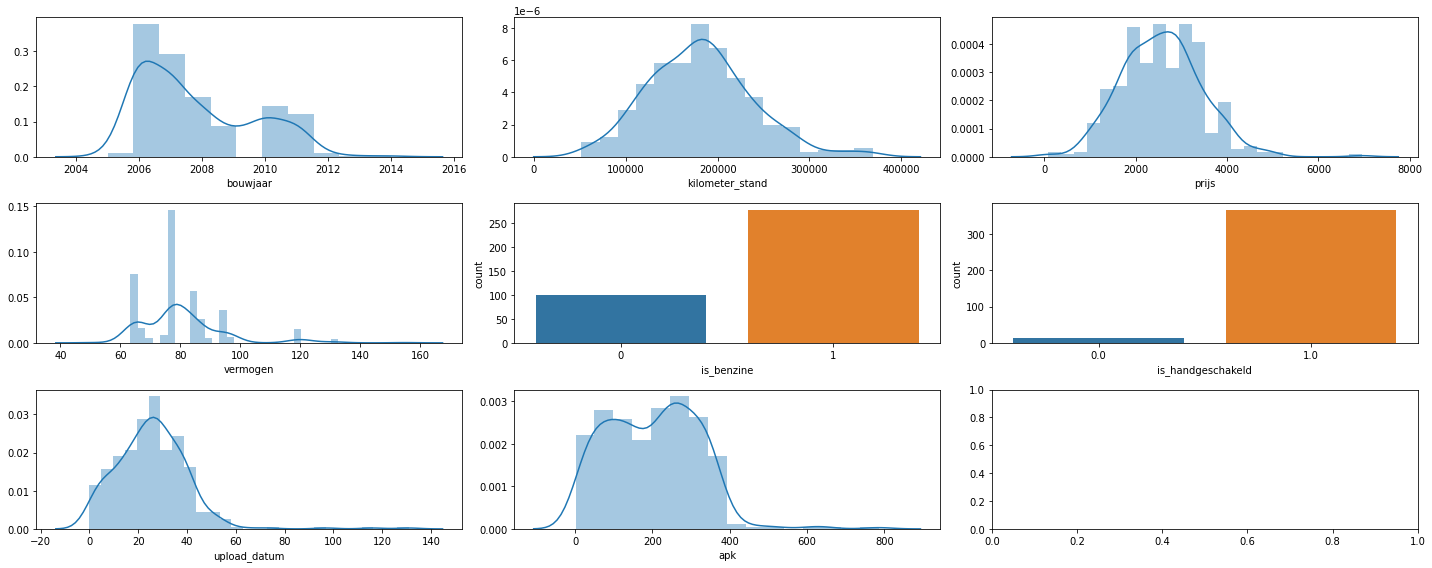

In [9]:
fig, axs = plt.subplots(3, 3, figsize=(20,8))

sns.distplot(df['bouwjaar'], ax=axs[0][0]);
sns.distplot(df['kilometer_stand'], ax=axs[0][1]);
sns.distplot(df['prijs'], ax=axs[0][2]);
sns.distplot(df['vermogen'], ax=axs[1][0]);
sns.countplot(df['is_benzine'], ax=axs[1][1]);
sns.countplot(df['is_handgeschakeld'], ax=axs[1][2]);
sns.distplot(df['upload_datum'], ax=axs[2][0]);
sns.distplot(df['apk'], ax=axs[2][1]);

plt.tight_layout()

# Scatter plots
Observations:
- The construction year is positively correlated
- The mileage is negatively correlated

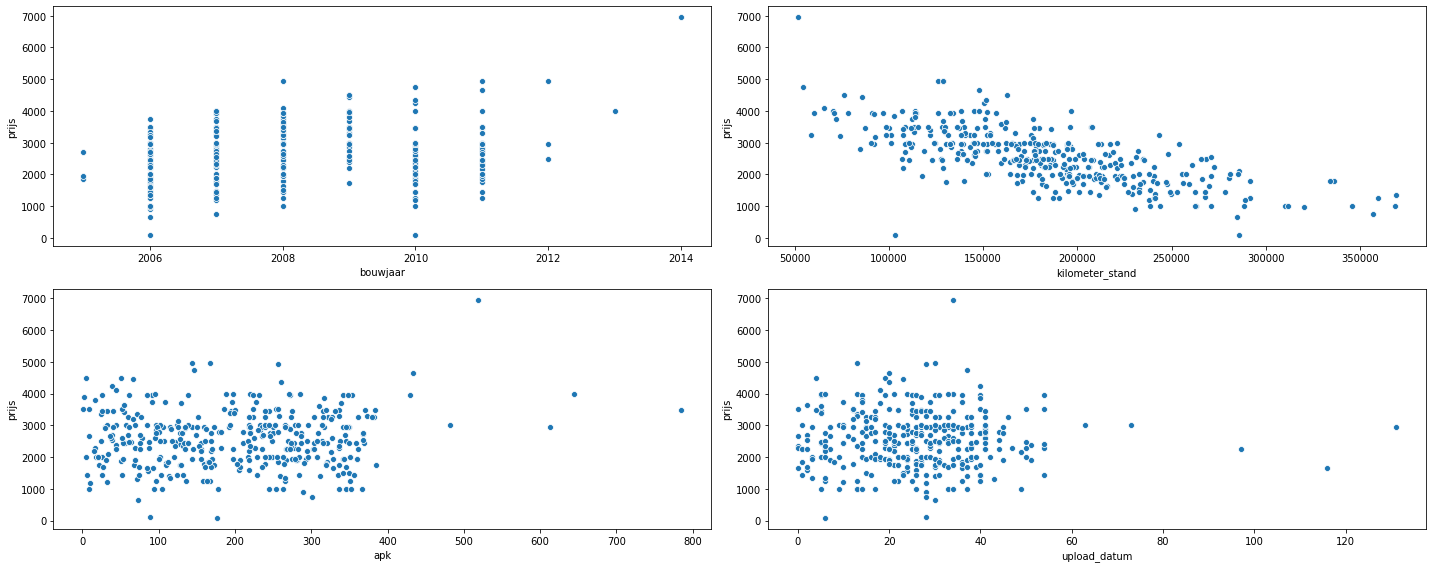

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(20,8))

col = 'bouwjaar'
data = pd.concat([df['prijs'], df[col]], axis=1)
sns.scatterplot(x=col, y='prijs', data=data, ax=axs[0][0]);

col = 'kilometer_stand'
data = pd.concat([df['prijs'], df[col]], axis=1)
sns.scatterplot(x=col, y='prijs', data=data, ax=axs[0][1]);

col = 'apk'
data = pd.concat([df['prijs'], df[col]], axis=1)
sns.scatterplot(x=col, y='prijs', data=data, ax=axs[1][0]);

col = 'upload_datum'
data = pd.concat([df['prijs'], df[col]], axis=1)
sns.scatterplot(x=col, y='prijs', data=data, ax=axs[1][1]);

plt.tight_layout()

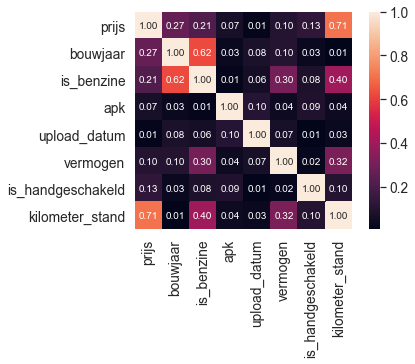

In [19]:
k = 10
corrmat = df.corr().sort_index(axis=0, ascending=True)
cols = corrmat.nlargest(k, 'prijs')['prijs'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
heatmap = sns.heatmap(np.absolute(cm), cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()